In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import swifter

In [3]:
import swifter

In [4]:
df_pancan=pd.read_csv('pancan.csv')
df_pancan.drop('Unnamed: 0',axis=1,inplace=True)

# Randomly choose fifty points from Dataset and Standardizing the dataset

In [64]:
df_pancan_sample=df_pancan.sample(n=50)
df_pancan_sample.shape


(50, 20531)

# Heirarchial Clustering

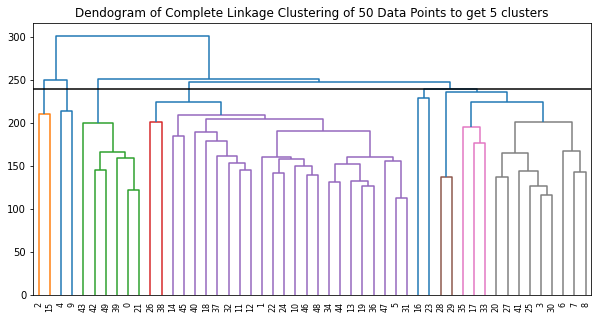

In [81]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_pancan_sample_scaled =pd.DataFrame(scaler.fit_transform(df_pancan_sample))

heirarchial_clustering=linkage(df_pancan_sample_scaled,method='complete')

# Plot a dendrogram of the hierarchical clustering
fig=plt.figure(figsize=(10, 5))
dendogram=dendrogram(heirarchial_clustering)
distance_threshold = heirarchial_clustering[-5, 2] 
# display the dendrogram

plt.xticks(rotation=90)
plt.title('Dendogram of Complete Linkage Clustering of 50 Data Points to get 5 clusters')
plt.axhline(y=distance_threshold, c='k')
# show the plot
plt.show()


# Cutting the Dendogram

In the code above, heirarchial_clustering variable stores the linkage matrix generated by hierarchical clustering.

The linkage matrix has n-1 rows and 4 columns, where n is the number of data points. Each row in the linkage matrix represents a cluster merger, with the first two columns specifying the indices of the clusters being merged, the third column representing the distance between these clusters, and the fourth column indicating the size of the newly formed cluster.

In hierarchical clustering, the number of clusters is determined by the distance threshold used to form clusters.

In the code above, the distance threshold that results in exactly five clusters is obtained by accessing the distance value corresponding to the fourth last row of the linkage matrix heirarchial_clustring, using the index notation heirarchial_Clustering[-5,2].

The reason why this works is because the linkage matrix heirarchial_clustering stores information about the merges that occur during hierarchical clustering in a specific order. The rows of the matrix are sorted in increasing order of the distances between the clusters being merged.

To obtain a specific number of clusters, we need to identify the distance threshold that will result in the desired number of clusters. We can do this by looking at the dendrogram and finding the vertical line that intersects with the desired number of clusters. Alternatively, we can use the linkage matrix and count the number of rows that will result in the desired number of clusters.

In this case, the [-5, 2] index notation accesses the distance value of the fourth last row of the linkage matrix. This distance value represents the distance between the clusters being merged that will result in five clusters. Therefore, using this distance threshold to form the final clusters will result in exactly five clusters.

In [66]:
distance_threshold = heirarchial_clustering[-5, 2] 
from scipy.cluster.hierarchy import fcluster
labels = fcluster(heirarchial_clustering, distance_threshold, criterion='distance')
print(labels)

[3 4 1 5 2 4 5 5 5 2 4 4 4 4 4 1 5 5 4 4 5 3 4 5 4 5 4 5 5 5 5 4 4 5 4 5 4
 4 4 3 4 5 3 3 4 4 4 4 4 3]


# Error Rate Calculation

In [67]:
def heirarchial_wss(input_dataframe,labels_array,no_of_clusters):
    input_dataframe_clustered=input_dataframe.copy()
    input_dataframe_clustered['Labels']=labels_array
    new_centroids=input_dataframe_clustered.groupby('Labels').mean()
    new_centroids=new_centroids.T
    total_error=[]
    for cluster in range(1,no_of_clusters+1):
        df_data_label_cluster=input_dataframe_clustered[input_dataframe_clustered['Labels']==cluster]
        df_data_label_cluster=df_data_label_cluster.drop('Labels',axis=1)
        centroids=pd.DataFrame(new_centroids[cluster])
        euclidean_distance=cdist(df_data_label_cluster,centroids.T,metric='euclidean')
        total_error.append(sum(euclidean_distance))
    return round(float(''.join(map(str, sum(total_error)))),3)    


In [68]:
heirarchial_wss(df_pancan_sample,labels,5)

7839.589

# Performing PCA on reduced Dataset

In [69]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

def covariance(input_dataframe):
    '''
    This function takse input as a standardized dataframe
    '''
    input_dataframe_mean = input_dataframe.swifter.apply(np.mean, axis=0)
    input_dataframe_centered= input_dataframe-input_dataframe_mean
    with tqdm(total=input_dataframe.shape[1], desc="Calculating Covariance Matrix") as pbar:
        cov_matrix=np.cov(input_dataframe.T)
        pbar.update()
    return cov_matrix,input_dataframe_centered

def principal_component_analysis(input_dataframe):
    '''
    This function takes input_dataframe,stadndardizes it and number of components as the number of components required by PC
    '''
    scaler = StandardScaler()
    input_dataframe_scaled =pd.DataFrame(scaler.fit_transform(input_dataframe))
    #Calling the covriance function
    covariance_matrix,input_dataframe_centered=covariance(input_dataframe_scaled)
    #Calculates Covariance Matirx
    eigen_values,eigen_vectors=np.linalg.eig(covariance_matrix)
    #Calculates Eigen Values and Eigen Vectors
    sorted_indices=np.argsort(eigen_values)
    #Sort the elements in descending order
    sorted_indices=sorted_indices[::-1]
    
    
    explained_variances = eigen_values / np.sum(eigen_values)
    variance_explained_ratios = pd.DataFrame(explained_variances[sorted_indices], columns=["variance_explained_ratio"])
    variance_explained_ratios["cumulative_variance_explained_ratio"] = variance_explained_ratios["variance_explained_ratio"].cumsum()
    #Find the number of components that explain 90% of variance
    number_of_components = variance_explained_ratios["cumulative_variance_explained_ratio"][variance_explained_ratios["cumulative_variance_explained_ratio"] <= 0.90].count() + 1
    print(variance_explained_ratios)
    print("Number of Principal components explain 90% of variance are {}".format(number_of_components))
    
    
    
    
    #Taking Top Eigen Values and Top Eigen Vectors
    top_eigen_values_indices=sorted_indices[:number_of_components]
    top_eigen_vectors=eigen_vectors[:,top_eigen_values_indices]
    
     #Variance Calculations Plot
    explained_variances = eigen_values/np.sum(eigen_values)
    variance_explained = pd.DataFrame(eigen_values[top_eigen_values_indices] / sum(eigen_values))
    variance_explained['PC_Feature']=top_eigen_values_indices
    variance_explained_plot=pd.Series(eigen_values[top_eigen_values_indices] / sum(eigen_values))
    
    
    #Cumulative Variance Plot
    cumulative_variance_explained = np.cumsum(variance_explained_plot)
    cumulative_variance_explained_plot = pd.Series(cumulative_variance_explained)
    
    
    
    #Projecting Principal Components 
    principal_components=input_dataframe_centered.dot(top_eigen_vectors)
    principal_components.columns=[f'PC{i+1}' for i in range(number_of_components)]
    
   
    
    #Calculate the loadings
    loadings = pd.DataFrame(top_eigen_vectors,index=input_dataframe.columns)
    
    df_principal_components=pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(number_of_components)])
    #PLotting the graph 
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(np.arange(1, number_of_components+1),variance_explained_plot, 'o-')
    ax[0].set_xlabel('Principal Component')
    ax[0].set_ylabel('Proportion of Variance Explained')
    ax[0].set_title('Scree Plot')
    
    
    ax[1].plot(np.arange(1, number_of_components+1),cumulative_variance_explained_plot, 'o-')
    ax[1].set_xlabel('Principal Component')
    ax[1].set_ylabel('Cumulative Proportion of Variance Explained')
    ax[1].set_title('Cumulative Scree Plot')
    plt.tight_layout()
    plt.show()
    
    #Correlation between PC1 and PC2
    
    plt.scatter(principal_components['PC1'], principal_components['PC2'])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Scatter plot of PC1 against PC2')
    plt.show()
    
    principal_components_temp=principal_components[['PC1','PC2']]
    corr_matrix = principal_components_temp.corr()
    print('Correlation matrix:')
    print(corr_matrix)
    
    total_variance_explained=cumulative_variance_explained_plot[1]
    print("The total variance explained by first two PC's is {}".format(total_variance_explained))

    return variance_explained,loadings,principal_components,cumulative_variance_explained
    
    
    
    



Calculating Covariance Matrix:   0%|          | 1/20531 [00:07<44:15:24,  7.76s/it]


         variance_explained_ratio  cumulative_variance_explained_ratio
0      1.113447e-01-2.198086e-34j                   0.111345-0.000000j
1      1.027723e-01-2.028856e-34j                   0.214117-0.000000j
2      8.437904e-02-1.665750e-34j                   0.298496-0.000000j
3      6.217397e-02-1.227393e-34j                   0.360670-0.000000j
4      5.442872e-02-1.074492e-34j                   0.415099-0.000000j
...                           ...                                  ...
20526 -3.628658e-18+7.163433e-51j                   1.000000-0.000000j
20527 -6.109925e-18+1.206177e-50j                   1.000000-0.000000j
20528 -6.738159e-18+1.330198e-50j                   1.000000-0.000000j
20529 -8.015101e-18+1.134305e-18j                   1.000000+0.000000j
20530 -8.015101e-18-1.134305e-18j                   1.000000-0.000000j

[20531 rows x 2 columns]
Number of Principal components explain 90% of variance are 34


/N/u/javshah/Carbonate/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


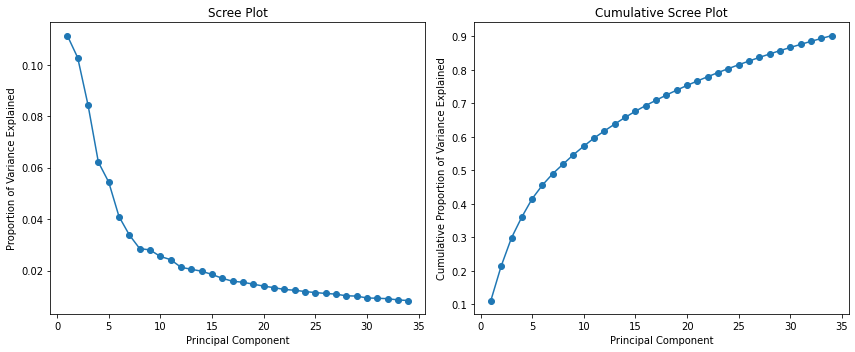

/N/u/javshah/Carbonate/.local/lib/python3.9/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


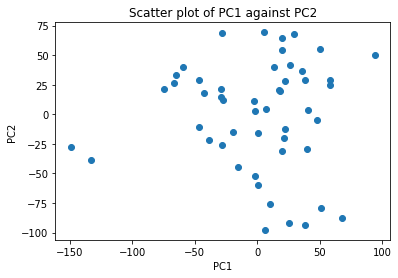

Correlation matrix:
              PC1           PC2
PC1  1.000000e+00 -3.320476e-16
PC2 -3.320476e-16  1.000000e+00
The total variance explained by first two PC's is (0.21411699772789528+0j)


/N/u/javshah/Carbonate/.local/lib/python3.9/site-packages/pandas/core/internals/managers.py:1768: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = arr.astype(dtype, copy=False)


In [70]:
variance_explained_50,loadings_50,principal_components_50,cumulative_variance_explained_50=principal_component_analysis(df_pancan_sample)

In [71]:
variance_explained_50.to_csv('variance_explained_50.csv')
loadings_50.to_csv('loadings_50.csv')
principal_components_50.to_csv('principal_components_50.csv')


In [74]:
principal_components_50.shape

(50, 34)

# Heirarchial clustering on reduced dataset

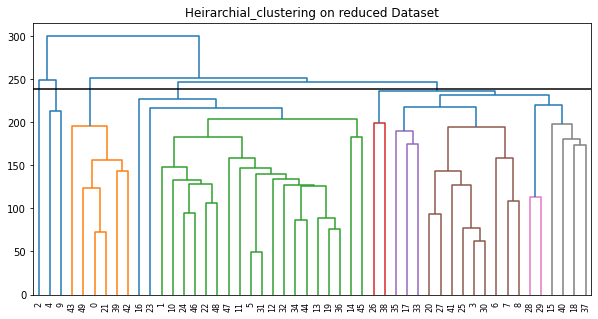

In [84]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
import matplotlib.pyplot as plt

heirarchial_clustering=linkage(principal_components_50,method='complete')


# plot a dendrogram of the hierarchical clustering
fig=plt.figure(figsize=(10, 5))
dendogram=dendrogram(heirarchial_clustering)

# display the dendrogram

plt.xticks(rotation=90)
plt.axhline(y=distance_threshold, c='k')
plt.title('Heirarchial_clustering on reduced Dataset')
# show the plot
plt.show()



# Cutting the dendograms

In [76]:
distance_threshold = heirarchial_clustering[-5, 2] 
from scipy.cluster.hierarchy import fcluster
labels = fcluster(heirarchial_clustering, distance_threshold, criterion='distance')
print(labels)

[3 4 2 5 1 4 5 5 5 1 4 4 4 4 4 5 4 5 5 4 5 3 4 4 4 5 5 5 5 5 5 4 4 5 4 5 4
 5 5 3 5 5 3 3 4 4 4 4 4 3]


In [78]:
def complex_euclidean_distance(u, v):
    return np.sqrt(np.sum(np.abs(u - v) ** 2))

def heirarchial_wss_complex(input_dataframe,labels_array,no_of_clusters):
    input_dataframe_clustered=input_dataframe.copy()
    input_dataframe_clustered['Labels']=labels_array
    new_centroids=input_dataframe_clustered.groupby('Labels').mean()
    new_centroids=new_centroids.T
    total_error=[]
    for cluster in range(1,no_of_clusters+1):
        df_data_label_cluster=input_dataframe_clustered[input_dataframe_clustered['Labels']==cluster]
        df_data_label_cluster=df_data_label_cluster.drop('Labels',axis=1)
        centroids=pd.DataFrame(new_centroids[cluster])
        euclidean_distance=cdist(df_data_label_cluster,centroids.T,metric=complex_euclidean_distance)
        total_error.append(sum(euclidean_distance))
    return round(float(''.join(map(str, sum(total_error)))),3)    


In [79]:
heirarchial_wss_complex(principal_components_50,labels,5)

5600.074

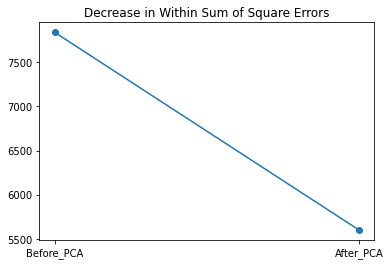

In [90]:
x=['Before_PCA','After_PCA']
y=[7839.589,5600.074]
plt.plot(x,y,'o-')
plt.title('Decrease in Within Sum of Square Errors')
plt.show()

# End of Document